In [1]:
import pandas as pd
import numpy as np
import copy as cp
import sklearn.metrics as metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA

In [3]:
from heatmap import heatmap, corrplot

## Load and Merge Data

In [4]:
onedrive_path = "C:/Users/cfowle/The Estée Lauder Companies Inc/TeamAnis - General/"

In [5]:
reviews = pd.read_csv(onedrive_path + "Data/Ratings and Reviews/reviews_demand_subcat.csv")
cc      = pd.read_csv(onedrive_path + "Data/Consumer Care/cc_product_month.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
products = pd.read_csv(onedrive_path + "Data/Product/product_codes.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,12,23,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(len(reviews))
reviews = reviews.drop("item_description", axis = 1).drop_duplicates()
print(len(reviews))

136630
122187


In [8]:
cc = cc.rename(columns = {"Date Month": "date", "P4": "itemid_4", "Brand Clean": "elc_brand"})
products = products.rename(columns = {"P4": "itemid_4", "brand": "elc_brand", "SubCategory":"sub_category"})
products = products[["elc_brand", "itemid_4", 'Major Category', 'Application', 'Category',
       'sub_category']].drop_duplicates(["elc_brand", "itemid_4"])

In [9]:
cc_product = cc.merge(products, how = "left", on = ["itemid_4", "elc_brand"])

In [10]:
cc_reviews_product = reviews.merge(cc_product, how = "left").fillna(0)
cc_reviews_product = cc_reviews_product.groupby(["elc_brand", "date", "sub_category"]).sum().reset_index()


## Feature Engineering
### Target Encoding

In [11]:
subcat_map = cc_reviews_product.groupby("sub_category")["demand"].mean().reset_index()
brand_map  = cc_reviews_product.groupby("elc_brand")["demand"].mean().reset_index()

cc_reviews_product["month"] = [x[-2:] for x in cc_reviews_product["date"].values]
cc_reviews_product["year"]  = [x[:4] for x in cc_reviews_product["date"].values]

month_map = cc_reviews_product.groupby("month")["demand"].mean().reset_index()
year_map  = cc_reviews_product.groupby("year")["demand"].mean().reset_index()

In [12]:
subcat_map = subcat_map.rename(columns = {"demand":"subcat_avg_demand"})
month_map  = month_map.rename(columns = {"demand":"month_avg_demand"})
year_map   = year_map.rename(columns = {"demand":"year_avg_demand"})
brand_map  = brand_map.rename(columns = {"demand":"brand_avg_demand"})

In [13]:
cc_reviews_product = cc_reviews_product.merge(subcat_map).merge(month_map).merge(year_map).merge(brand_map)
cc_reviews_product = cc_reviews_product.sort_values("date")

### Create dataset without customer data

In [14]:
non_customer_data = cc_reviews_product[["date", "demand_F1", "demand", "demand_P2", "demand_P1",
                                   "subcat_avg_demand", "month_avg_demand", "year_avg_demand", "brand_avg_demand",
                                   "month", "year"]]

### Create Dataset with only Relative Measures

In [15]:
relative_data = cp.deepcopy(non_customer_data)
subcat = cc_reviews_product ##just here so I can copy some old code easily

In [16]:
relative_data["percent_1"] = subcat["rating_1"]/subcat["nb_reviews"]
relative_data["percent_2"] = subcat["rating_2"]/subcat["nb_reviews"]
relative_data["percent_3"] = subcat["rating_3"]/subcat["nb_reviews"]
relative_data["percent_4"] = subcat["rating_4"]/subcat["nb_reviews"]
relative_data["percent_5"] = subcat["rating_5"]/subcat["nb_reviews"]

In [17]:
relative_data["percent_negative"] = subcat['sentiment_negative']/subcat["nb_reviews"]
relative_data["percent_neutral"] = subcat['sentiment_neutral']/subcat["nb_reviews"]
relative_data["percent_positive"] = subcat['sentiment_positive']/subcat["nb_reviews"]

In [18]:
relative_data = relative_data.merge(subcat_map).merge(month_map).merge(year_map).merge(brand_map)
relative_data = relative_data.sort_values("date").reset_index(drop=True)
relative_data = relative_data.fillna(0)

In [19]:
full_relative_data = cp.deepcopy(relative_data)

In [20]:
subcat["cc_tot"] = subcat['Complaints'] + subcat['Compliments'] + subcat['Questions'] + subcat['Suggestions']

In [21]:
cc_counts = cc.drop(['Product Code', 'itemid_4', 'elc_brand', "date"], axis = 1).columns

In [22]:
for col in cc_counts:
    full_relative_data["percent_" + col] = subcat[col]/subcat["cc_tot"]

In [23]:
full_relative_data = full_relative_data.fillna(0)

In [24]:
full_relative_data

,date,demand_F1,demand,demand_P2,demand_P1,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand,month,...,percent_Questions_Order_Returns,percent_Questions_Product_General,percent_Questions_Product_Packaging,percent_Questions_Product_Performance,percent_Questions_Product_Usage Related,percent_Questions_Service_Location,percent_Questions_Service_Miscellaneous,percent_Questions_Website_Offer Codes,percent_Questions_Website_Website functionality,percent_Suggestions_Suggestion_Miscellaneous
0,2014-12,195.0,0,0.0,0.0,1906.184615,31816.180952,25517.980220,1659.630769,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-12,0.0,0,0.0,0.0,3109.058974,31816.180952,25517.980220,7695.969900,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-12,10.0,40,14.0,26.0,6363.111111,31816.180952,25517.980220,7695.969900,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-12,63.0,3,480.0,626.0,2584.835897,31816.180952,25517.980220,7695.969900,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-12,137240.0,23846,73311.0,31094.0,43097.447337,31816.180952,25517.980220,7695.969900,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29700,2020-04,2833.0,552,3871.0,1872.0,5799.789744,21587.236264,19931.730769,66774.171748,04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29701,2020-04,11471.0,7036,35753.0,20538.0,32732.323077,21587.236264,19931.730769,66774.171748,04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29702,2020-04,21111.0,13666,212473.0,34592.0,10997.128205,21587.236264,19931.730769,66774.171748,04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29703,2020-04,0.0,0,0.0,0.0,2711.886154,21587.236264,19931.730769,13684.797041,04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build Model with Customer Data

In [25]:
X = relative_data.drop(["demand_F1", "date", "sub_category", "elc_brand"], axis = 1)
y = relative_data[["demand_F1"]]
X.columns

Index(['demand', 'demand_P2', 'demand_P1', 'subcat_avg_demand',
       'month_avg_demand', 'year_avg_demand', 'brand_avg_demand', 'month',
       'year', 'percent_1', 'percent_2', 'percent_3', 'percent_4', 'percent_5',
       'percent_negative', 'percent_neutral', 'percent_positive'],
      dtype='object')

Text(0, 0.5, 'cumulative explained variance')

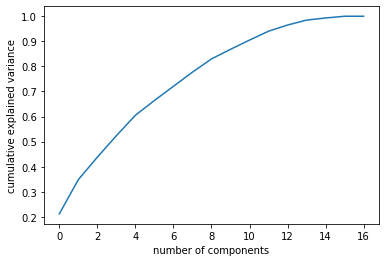

In [26]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [27]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [28]:
#principalDf.to_csv(onedrive_path + "Output/2020_06_22_to_rama/pca.csv")

In [29]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)

In [30]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [31]:
tree_param = {'max_depth': [2, 3, 5, 7],
             'min_samples_split':  [2, 4, 18, 16, 32, 64],
             'min_samples_leaf': [2, 4, 18, 16, 32, 64]}
clf = GridSearchCV(tree, tree_param, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 4, 18, 16, 32, 64],
                         'min_samp

In [32]:
clf.best_score_

0.8092377082652373

In [33]:
pred = clf.best_estimator_.predict(X_test)
metrics.r2_score(pred, y_test)

0.8056516785106262

## What if we remove Demand Lags

In [34]:
no_lags = relative_data[['subcat_avg_demand',
       'month_avg_demand', 'year_avg_demand', 'brand_avg_demand', 'month',
       'year', 'percent_1', 'percent_2', 'percent_3', 'percent_4', 'percent_5',
       'percent_negative', 'percent_neutral', 'percent_positive']]

Text(0, 0.5, 'cumulative explained variance')

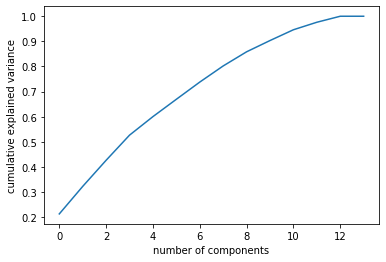

In [35]:
X = StandardScaler().fit_transform(no_lags)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [36]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

tree_param = {'max_depth': [2, 3, 5, 7],
             'min_samples_split':  [2, 4, 18, 16, 32, 64],
             'min_samples_leaf': [2, 4, 18, 16, 32, 64]}
clf = GridSearchCV(tree, tree_param, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 4, 18, 16, 32, 64],
                         'min_samp

In [38]:
clf.best_score_

0.6548935541914265

In [39]:
pred = clf.best_estimator_.predict(X_test)
metrics.r2_score(pred, y_test)

0.3108108560090186

## What if I didn't do PCA?

In [40]:
X_train, X_test, y_train, y_test = train_test_split(no_lags, y, shuffle = False)
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

tree_param = {'max_depth': [2, 3, 4],
             'min_samples_split':  [2, 4, 18, 16, 32, 64],
             'min_samples_leaf': [2, 4, 18, 16, 32, 64]}
clf = GridSearchCV(tree, tree_param, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_leaf': [2, 4, 18, 16, 32, 64],
                         'min_samples

In [41]:
clf.best_score_

0.40092876380641795

In [42]:
pred = clf.best_estimator_.predict(X_test)
metrics.r2_score(pred, y_test)

0.4033315334404677

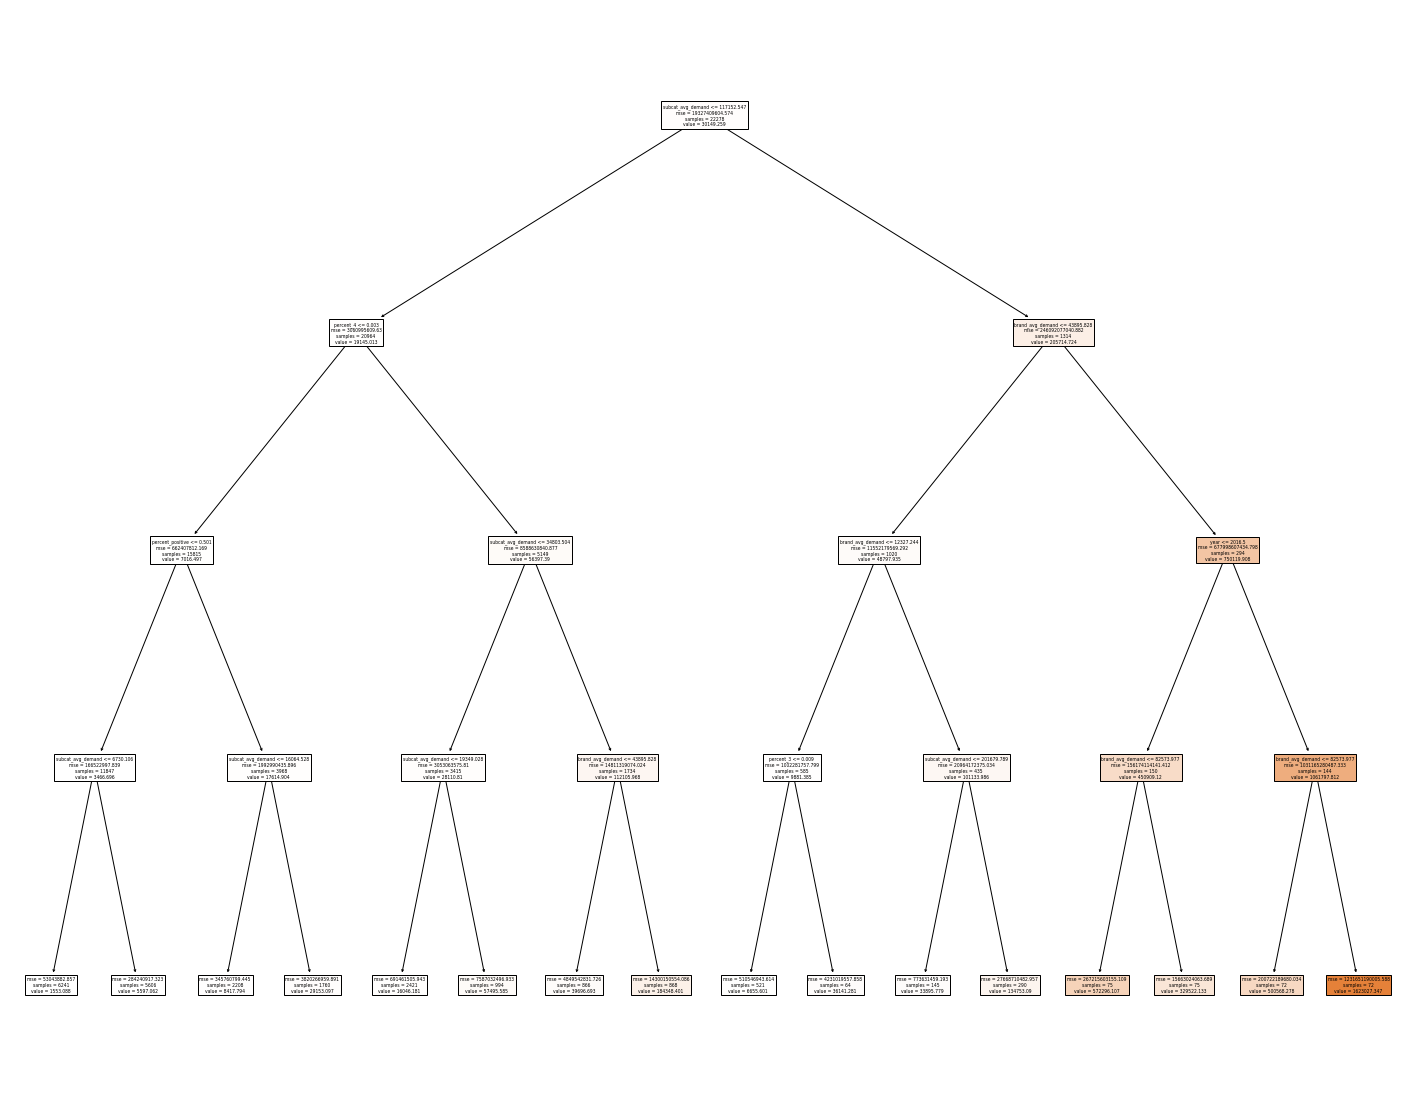

In [43]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf.best_estimator_,
            feature_names=no_lags.columns,
            filled=True)

## What if we removed all demand data

In [44]:
no_demand = relative_data[['month','year', 'percent_1', 'percent_2', 'percent_3', 'percent_4', 'percent_5',
       'percent_negative', 'percent_neutral', 'percent_positive']] 

Text(0, 0.5, 'cumulative explained variance')

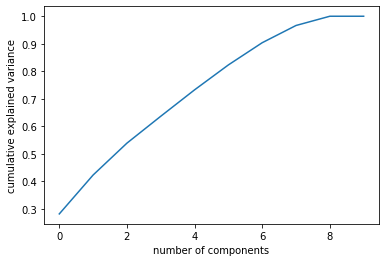

In [45]:
X = StandardScaler().fit_transform(no_demand)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [46]:
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

tree_param = {'max_depth': [2, 3, 5, 7],
             'min_samples_split':  [2, 4, 18, 16, 32, 64],
             'min_samples_leaf': [2, 4, 18, 16, 32, 64]}
clf = GridSearchCV(tree, tree_param, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 4, 18, 16, 32, 64],
                         'min_samp

In [48]:
clf.best_score_

0.08591945868153014

In [49]:
pred = clf.best_estimator_.predict(X_test)
metrics.r2_score(pred, y_test)

-8.926605760624291